# Model training and evaluation
In this notebook, we present the best models we found for these methods: logistic regression, SVC/SVM, 2-layer neural network, CNN, random forest and XGBoost.

## Load Dataset

In [ ]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
training_folder = 'training_data/'

# instantiate empty arrays for features and labels
X = np.array([])
y = np.array([])
k = 0 # initialize

# load data from the relevant files
while True:
  try:
    # load data file
    class_k = np.loadtxt(training_folder + 'Class{:}.csv'.format(k))
    # extract features and labels
    class_k_features = class_k[:,:-1] # extract features
    class_k_labels  = class_k[:,-1].astype(np.int) # labels; convert to int
    # append the features and labels to the arrays
    X = np.vstack([X,class_k_features]) if X.size else class_k_features
    y = np.hstack([y,class_k_labels]) if y.size else class_k_labels
    # increment counter
    k += 1
  except:
      print('loaded %i classes of training data' %k)
      break

# examine shape
num_classes = k
num_features = X.shape[1]
num_samples = X.shape[0]

print('unique labels: ', np.unique(y))
print('number of features: ', num_features)
print('number of samples: ', num_samples)

loaded 20 classes of training data
unique labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
number of features:  20
number of samples:  100000


Next, we standardize the dataset such that all features have zero mean and unit variance.

In [ ]:
import sklearn.preprocessing

# standardize dataset
X = sklearn.preprocessing.scale(X)

Since our dataset is large, we split the dataset into 70% for training and 30% for test.

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3, shuffle=True)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
#Defined the model with optimized parameters
model=LogisticRegression(C = 55.0, max_iter= 5000, \
                         multi_class= 'multinomial', \
                         penalty = 'l1', solver = 'saga')
t1 = time.time()
#Training 
model.fit(Xtr,ytr)
t_train = time.time() - t1

#print("score",logreg2.score(x_test,y_test))
t1 = time.time()
# evaluate predictions
y_pred = model.predict(Xts)
t_test = time.time() - t1

predictions = [round(value) for value in y_pred]
#Accuracy calculations
accuracy = accuracy_score(yts, predictions)
print("Accuracy: %.2f%%, train time: %.fs, test time: %.fs" % \
      (accuracy * 100.0, t_train, t_test))

Accuracy: 86.94%, train time: 117s, test time: 0s


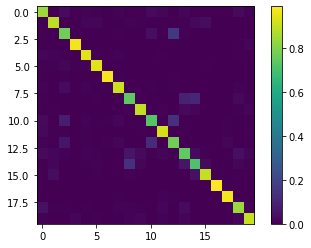

In [ ]:
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
C = confusion_matrix(yts,predictions)

# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[:, None]

# Print the confusion matrix
# print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

In [ ]:
import pickle
# save the model
with open( "best_logreg.sav", "wb" ) as fp:
    pickle.dump( model, fp )

## SVM

We explore Linear and RBF kernel to see which can give better accuracy. We also create a list of  C and 𝛾  values to figure out the best parameter setting, and they are created in a logarithmic range:

C_range = np.logspace(-1, 2, 12)

gam_range = np.logspace(-5, 1, 6)

The search results are shown in the **screenshots** below:

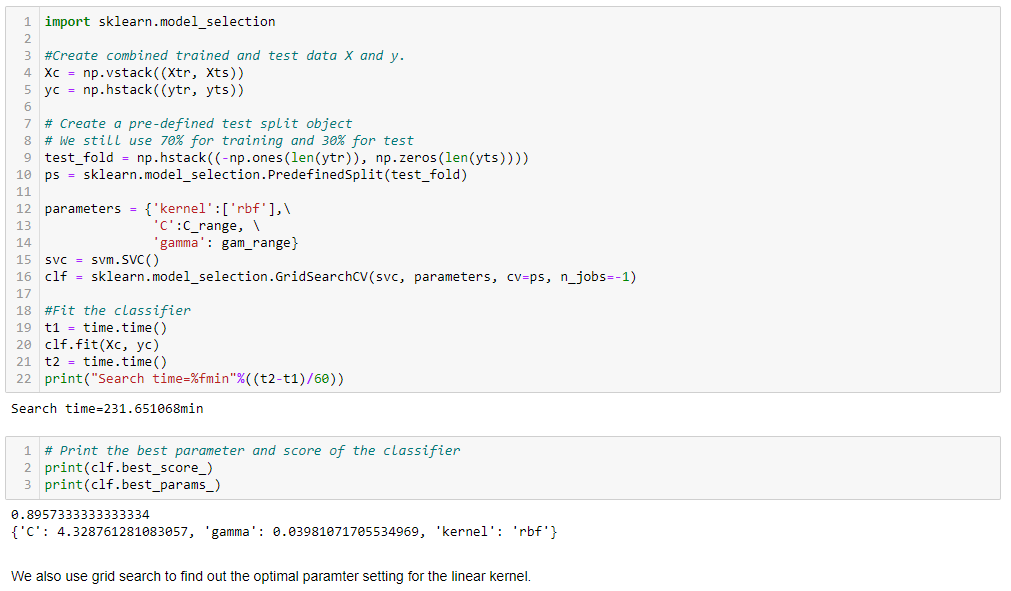
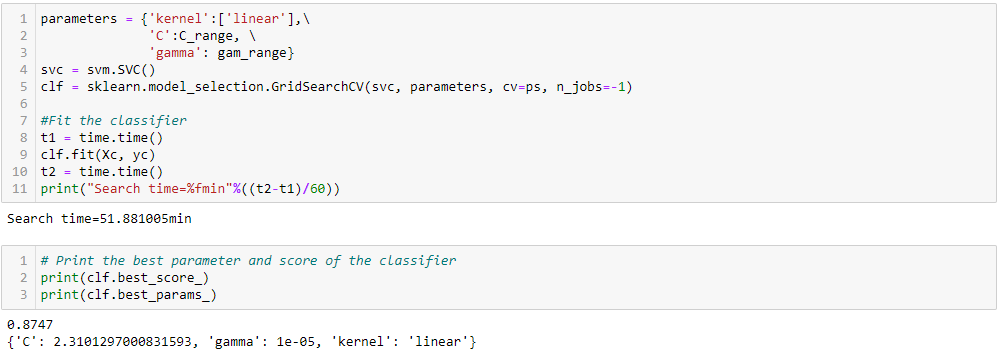

In [ ]:
from sklearn import svm

# train the classifier with the search result
svc = svm.SVC(kernel='rbf', C=4.328761281083057, gamma=0.03981071705534969)

t1 = time.time()
svc.fit(Xtr,ytr)
t_train = time.time()-t1

# Evaluate on the test set
t1 = time.time()
yhat_ts = svc.predict(Xts)
t_test = time.time() - t1

acc = np.mean(yts==yhat_ts)

print("Test accuracy=%.4f, train time: %fs, test time: %fs"%(acc, t_train, t_test))

Test accuracy=0.8991, train time: 37.321574s, test time: 36.277869s


Save the best SVM model with RBF kernel.

In [ ]:
import pickle
# save the model
with open( "best_svm.sav", "wb" ) as fp:
    pickle.dump( svc, fp )

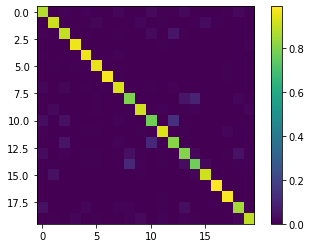

In [ ]:
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
C = confusion_matrix(yts,yhat_ts)

# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[:, None]

# Print the confusion matrix
# print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

## 2-layer neural network

In [ ]:
#Importing all the required modules
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

__Create a Pytorch dataset and dataloader__

A dataset is a pytorch object that contains your training dataset. Here we will use the TensorDataset function to create a dataset from a tensor, but you can also create datasets from folders or use preconfigured datasets for many popular machine learning tasks.
A dataloader is an object that loads the data from the dataset into your model. We will be using a batch size of 100. 

In [ ]:
batch_size = 100

# Convert the numpy arrays to PyTorch tensors
Xtr_torch = torch.Tensor(Xtr)
ytr_torch = torch.Tensor(ytr)
Xts_torch = torch.Tensor(Xts)
yts_torch = torch.Tensor(yts)

# Create a training Dataset
train_ds = torch.utils.data.TensorDataset(Xtr_torch, ytr_torch)
# Creates a training DataLoader from this Dataset
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True) 

# Create a testing Dataset
test_ds = torch.utils.data.TensorDataset(Xts_torch, yts_torch)
# Creates a testing DataLoader from this Dataset
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

__Creating a Simple Neural Network__

torch.nn contains all the basic building blocks to build your neural network
Building a Neural Network in Pytorch is as simple as defining a class with two methods: __ init __ and forward.

__ init __

This method initiates the model. First we initiate the network as an nn.Module. Then we add the layers and other necessary components. nn.Linear(chan_in, chan_out) creates a linear (also called fully-connected, or dense) layer with chan_in input channels and chan_out output channels. This first layer will have chan_in=nin, the number of inputs to the network, and chan_out=nh, the number of hidden nodes. The second layer, which is also our final or output layer, will have chan_in=nh inputs, which are the outputs of the previous layer, and chan_out=nout outputs, which is the number of outputs of the network.  nn.PReLU creates a PReLU activation function.

__forward__

This is the method that is called when you pass data through the network. The first dense layer is implemented and its output is passed through the activation function. The result is then passed through the second dense layer.

In [ ]:
nin = X.shape[1] # dimension of input data
nh = 500 # number of hidden units
nout = int(np.max(y)+1) 

class Net(nn.Module):
    def __init__(self,nin,nh,nout):
        super(Net,self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(nin,nh),
            nn.BatchNorm1d(nh), #applying batch norm
            nn.PReLU(),#Activation function applied
            nn.Dropout(0.5),#applying droupout
            nn.Linear(nh,nout)
        )
        
    def forward(self,x):
        x = x.view(x.size(0), -1) #x.view(x.size(0), -1) is flattening the tensor, this is because the Linear layer only accepts a vector (1d array)
        x = self.classifier(x)
        return x

model = Net(nin=nin, nh=nh, nout=nout)

__Training the Network__

To train the network, we have to select an optimizer and a loss function.
optim.Adam(model.parameters(), lr=0.001) intantiates an optimizer that is linked to the parameters of our model. It also sets the learning rate to 0.001. The learning rate is a tunable parameter.
nn.CrossEntropyLoss() creates a function that we will call later to compute the loss

In [ ]:
opt = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Now it's time to actually train the network. We will iterate over the training data num_epoch times. Iterating over the data is performed using an enumerator constructed from the dataloader object, loader. During each inner-loop iteration, one mini-batch of training data is processed.

In [ ]:
num_epoch = 100 #Number of epochs

start = timer()

a_tr_loss = np.zeros([num_epoch])
a_tr_accuracy = np.zeros([num_epoch])
a_ts_loss = np.zeros([num_epoch])
a_ts_accuracy = np.zeros([num_epoch])
predicted_sum = []

for epoch in range(num_epoch):

    model.train() # put model in training mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss_tr = []
    # iterate over training set
    for train_iter, data in enumerate(train_loader):
        x_batch,y_batch = data
        y_batch = y_batch.type(torch.long)
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch)
        batch_loss_tr.append(loss.item())
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        # Do hard classification: index of largest score
        _, predicted = torch.max(out.data, 1)
        # Compute number of decision errors
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    a_tr_loss[epoch] = np.mean(batch_loss_tr) # Compute average loss over epoch
    a_tr_accuracy[epoch] = 100*correct/total

    model.eval() # put model in evaluation mode
    correct = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss_ts = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            labels = labels.type(torch.long)
            outputs = model(images)
            batch_loss_ts.append(criterion(outputs,labels).item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    a_ts_loss[epoch] = np.mean(batch_loss_ts)
    a_ts_accuracy[epoch] = 100*correct/total
    predicted_sum.append(predicted)
    # Print details every print_mod epoch
    print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
          +'Train Accuracy: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch])
          +'Test Accuracy: {0:.2f}'.format(a_ts_accuracy[epoch]))
end = timer()
print('Excecution time(Hrs/mins/secs):',timedelta(seconds=end-start))

Epoch:  1   Train Loss: 0.705   Train Accuracy: 78.49    Test Loss: 0.450   Test Accuracy: 85.49
Epoch:  2   Train Loss: 0.503   Train Accuracy: 83.23    Test Loss: 0.400   Test Accuracy: 86.48
Epoch:  3   Train Loss: 0.470   Train Accuracy: 83.90    Test Loss: 0.376   Test Accuracy: 87.19
Epoch:  4   Train Loss: 0.445   Train Accuracy: 84.63    Test Loss: 0.357   Test Accuracy: 87.90
Epoch:  5   Train Loss: 0.420   Train Accuracy: 85.42    Test Loss: 0.335   Test Accuracy: 88.77
Epoch:  6   Train Loss: 0.408   Train Accuracy: 85.85    Test Loss: 0.324   Test Accuracy: 89.11
Epoch:  7   Train Loss: 0.400   Train Accuracy: 86.03    Test Loss: 0.316   Test Accuracy: 89.35
Epoch:  8   Train Loss: 0.391   Train Accuracy: 86.31    Test Loss: 0.307   Test Accuracy: 89.53
Epoch:  9   Train Loss: 0.381   Train Accuracy: 86.69    Test Loss: 0.303   Test Accuracy: 89.65
Epoch: 10   Train Loss: 0.377   Train Accuracy: 86.68    Test Loss: 0.299   Test Accuracy: 89.93
Epoch: 11   Train Loss: 0.376 

__Plotting the Traning and Test accuracy versus no. of epochs__

max test accuracy: 90.86


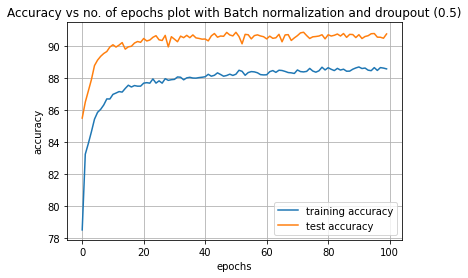

In [ ]:
print("max test accuracy: %.2f"%(np.max(a_ts_accuracy)))
%matplotlib inline
plt.plot(a_tr_accuracy)
plt.plot(a_ts_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy vs no. of epochs plot with Batch normalization and droupout (0.5)')
plt.legend(['training accuracy', 'test accuracy'])

__Creating the confusion matrix and plotting it__

In [ ]:
correct = 0
total = 0
C = np.zeros((20,20))
all_labels = torch.tensor([])
all_preds = torch.tensor([])
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels = labels.type(torch.long)
        all_labels = torch.cat((all_labels, labels),dim = 0)
        outputs = model(images)
        _,predicted = torch.max(outputs.data, 1)
        all_preds = torch.cat((all_preds, predicted),dim = 0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100*correct/total
print("accuracy = %f" % acc)
print((all_preds))
print((all_labels))


accuracy = 90.750000
tensor([ 2.,  9.,  9.,  ...,  3.,  5., 18.])
tensor([13.,  9.,  9.,  ...,  3.,  5., 18.])


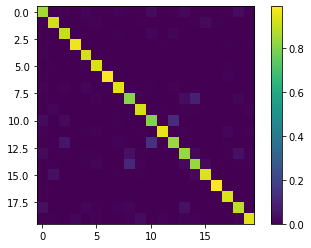

In [ ]:
def conf_matrix(y_true, yhat):
  
  C = confusion_matrix(y_true, yhat)
  # Normalize the confusion matrix
  Csum = np.sum(C,0)
  # print(Csum[:,None])
  C = C / Csum[:,None]
  plt.imshow(C, interpolation='none')
  plt.colorbar()
cm = conf_matrix(all_labels, all_preds)

In [ ]:
# Save 
PATH = "best_nn.pth"

with torch.no_grad():
    traced_cell = torch.jit.trace(model, (torch.Tensor(X)))
torch.jit.save(traced_cell, PATH)

## CNN Deep Neural Network

In the following block we define a dataset class for the data loader.

In [ ]:
from torch.utils.data import Dataset, DataLoader
class ProjectDataset(Dataset):

    def __init__(self, samples, targets, transform=None):
        self.samples = samples
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):  
        label = self.targets[index]
        sample = self.samples[index,:]
        sample = sample.reshape(1,-1)
        if self.transform:
            sample = self.transform(sample)
        return (sample, label)

Load dataset using data loader.

In [ ]:
import torch
from torchvision import transforms
# transform = transforms.ToTensor()
batch_size = 100
train_ds = ProjectDataset(Xtr, ytr)
test_ds = ProjectDataset(Xts, yts)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

# print one sample
xx, yy = next(iter(train_dl))
print(xx[0])
print(yy[0])

tensor([[-0.3573, -0.6138, -0.3287, -1.0153, -0.7815,  0.0984, -0.7074,  1.2499,
         -0.4612, -0.2412, -0.0168, -0.4169, -0.8417, -1.4392, -1.2501, -0.4910,
         -0.6649, -0.5931, -0.5833, -0.3049]], dtype=torch.float64)
tensor(17)


In [ ]:
# define the device to run
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cuda:0


Define a function to plot confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix
# define the function to plot confusion matrix for a specific model
def conf_matrix(model):
  # load all data in test set
  test_dl2 = DataLoader(test_ds, batch_size=len(yts), shuffle=False)

  model.eval() # put model in evaluation mode
  with torch.no_grad():
      x, labels = next(iter(test_dl2))
      x = x.type(torch.float32)
      x = x.to(device)
      labels = labels.to(device)
      outputs = model(x)
      _, predicted = torch.max(outputs.data, 1)

  yhat = predicted.cpu().numpy() 
  y_true = labels.cpu().numpy()

  C = confusion_matrix(y_true, yhat)

  # Normalize the confusion matrix
  Csum = np.sum(C,0)
  # print(Csum[:,None])
  C = C / Csum[:,None]
  # print(np.mean(C,0))

  # Print the confusion matrix
  # print(np.array_str(C, precision=3, suppress_small=True))
  plt.imshow(C, interpolation='none')
  plt.colorbar()

Define training and testing function.

In [ ]:
# define model training function
def model_train(model, opt, scheduler):
  correct = 0 # initialize error counter
  total = 0 # initialize total counter
  model.train() # put model in training mode
  # iterate over training set

  for train_iter, data in enumerate(train_dl):
    x_batch,y_batch = data
    x_batch = x_batch.type(torch.float32)
    x_batch = x_batch.to(device)
    y_batch = y_batch.long()
    y_batch = y_batch.to(device)
    out = model(x_batch)
    # Compute Loss
    loss = criterion(out,y_batch)
    # Zero gradients
    opt.zero_grad()
    # Compute gradients using back propagation
    loss.backward()
    # Take an optimization 'step'
    opt.step()
    
    # Compute Accuracy
    _, predicted = torch.max(out.data, 1)
    total += y_batch.size(0)
    correct += (predicted == y_batch).sum().item()
  
  # Take scheduler step
  scheduler.step()

  accu = 100*correct/total
  return accu

# define model validation function
def model_val(model):
  correct = 0
  total = 0
  model.eval() # put model in evaluation mode
  with torch.no_grad():
    for data in test_dl:
      xs, labels = data
      xs = xs.type(torch.float32)
      xs = xs.to(device)
      labels = labels.to(device)
      outputs = model(xs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  accu = 100*correct/total
  return accu

The following network is the most optimized one in our documentation.

In [ ]:
import torch
import torch.nn as nn

class bndrop8(nn.Module):
  def __init__(self):
    super(bndrop8, self).__init__()
    self.leakyrelu = nn.LeakyReLU()
    self.conv1 = nn.Conv1d(1,128,3,padding=1)
    self.pool = nn.MaxPool1d(2,2)
    self.bn1 = nn.BatchNorm1d(128)
    self.dropout1 = nn.Dropout2d(p=0.5)
    # self.conv2 = nn.Conv1d(128,128,3,padding=1)
    self.bn2 = nn.BatchNorm1d(128*10)
    self.dropout2 = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(128*10, 256)
    self.bn3 = nn.BatchNorm1d(256)
    self.dropout3 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(256, 20)

  def forward(self, x):
    x = self.bn1(self.pool(self.leakyrelu(self.conv1(x))))
    # x = self.pool(self.leakyrelu(self.conv2(x)))
    x = self.dropout2(self.bn2(x.view(x.size(0),-1)))
    x = self.dropout3(self.bn3(self.leakyrelu(self.fc1(x))))
    x = self.fc2(x)

    return x

model = bndrop8()
model.to(device)


bndrop8(
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (bn2): BatchNorm1d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1280, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
)

Initialize optimizer and scheduler.

In [ ]:
import torch.optim as optim

epochs = 100
lrate = 0.001
decay = lrate/epochs

# initiate Adam optimizer
opt = optim.Adam(model.parameters(), lr=lrate)

# Create learning rate scheduler 
lambda1 = lambda epoch: 1/(1 + decay * epoch)
scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

# initiate loss function for multi-class classification
criterion = nn.CrossEntropyLoss()


Start training!

In [ ]:
import time

bndrop8_tr_accuracy = []
bndrop8_ts_accuracy = []

t1 = time.time()
for epoch in range(epochs):
    
  accu_train = model_train(model, opt, scheduler)
  bndrop8_tr_accuracy.append( accu_train )
  
  accu_val = model_val(model)
  bndrop8_ts_accuracy.append( accu_val )

  # Print details every print_mod epoch
  print('Epoch: {0:2d}   Train Accuracy: {1:.3f}%   Test Accuracy: {2:.3f}%'\
        .format(epoch+1, bndrop8_tr_accuracy[epoch], bndrop8_ts_accuracy[epoch]))
t2 = time.time()
print('Average time per epoch: %f s'%((t2-t1)/epochs))


Epoch:  1   Train Accuracy: 81.580%   Test Accuracy: 88.120%
Epoch:  2   Train Accuracy: 84.989%   Test Accuracy: 88.740%
Epoch:  3   Train Accuracy: 85.679%   Test Accuracy: 89.280%
Epoch:  4   Train Accuracy: 86.033%   Test Accuracy: 89.500%
Epoch:  5   Train Accuracy: 86.323%   Test Accuracy: 89.060%
Epoch:  6   Train Accuracy: 86.439%   Test Accuracy: 89.800%
Epoch:  7   Train Accuracy: 86.681%   Test Accuracy: 90.110%
Epoch:  8   Train Accuracy: 86.876%   Test Accuracy: 89.973%
Epoch:  9   Train Accuracy: 86.936%   Test Accuracy: 90.063%
Epoch: 10   Train Accuracy: 87.324%   Test Accuracy: 90.140%
Epoch: 11   Train Accuracy: 87.349%   Test Accuracy: 89.853%
Epoch: 12   Train Accuracy: 87.400%   Test Accuracy: 90.400%
Epoch: 13   Train Accuracy: 87.577%   Test Accuracy: 90.450%
Epoch: 14   Train Accuracy: 87.554%   Test Accuracy: 90.393%
Epoch: 15   Train Accuracy: 87.647%   Test Accuracy: 90.357%
Epoch: 16   Train Accuracy: 87.603%   Test Accuracy: 90.090%
Epoch: 17   Train Accura

Max test accuracy: 91.06%


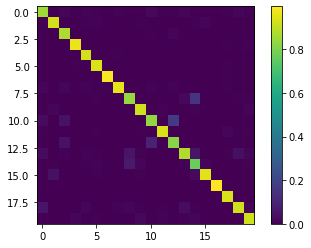

In [ ]:
# plot confusion matrix
max_ts_accu = max(bndrop8_ts_accuracy)
print("Max test accuracy: {0:.2f}%".format(max_ts_accu))
conf_matrix(model)

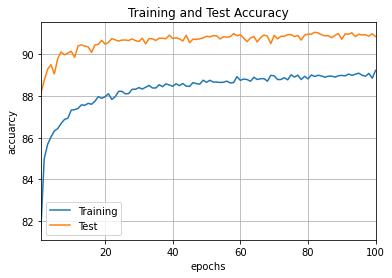

In [ ]:
# plot training and test accuracy 
epochsn=np.arange(1,epochs+1)
plt.plot(epochsn,bndrop8_tr_accuracy)
plt.plot(epochsn,bndrop8_ts_accuracy)
plt.xlim((1,epochs))

plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.title('Training and Test Accuracy')
plt.legend(['Training', 'Test'])

Save the best CNN model.

In [ ]:
# Save 
PATH = "best_cnn.pth"
xx = X[:,np.newaxis,:]
model = model.cpu() # save model to run on CPU only
with torch.no_grad():
    traced_cell = torch.jit.trace(model, (torch.Tensor(xx)))
torch.jit.save(traced_cell, PATH)

## Random Forest

In [ ]:
#Importing all the required modules
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from timeit import default_timer as timer
from datetime import timedelta

__Implementing Random Forest Classifier__

In [ ]:
start = timer()
classifier = RandomForestClassifier(n_estimators = 1000, max_features=0.3) #Defining the parameters in Random Forest Classifier
classifier.fit(Xtr, ytr) #Fitting the training and the test data
y_pred = classifier.predict(Xts) #Predicting using the test data
result = accuracy_score(yts,y_pred)# Calculating the accuracy of the model
print("Accuracy: %.2f%%" %(result*100.0))
end = timer()
print('Excecution time(Hrs/mins/secs):',timedelta(seconds=end-start))

Accuracy: 89.46%
Excecution time(Hrs/mins/secs): 0:09:57.593880


Plot the confusion matrix.

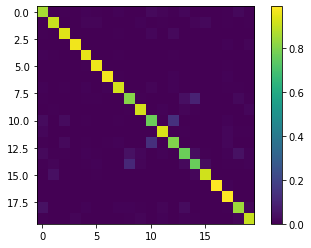

In [ ]:
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
C = confusion_matrix(yts,y_pred)

# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[:, None]

# Print the confusion matrix
# print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

In [ ]:
import bz2
import pickle
import _pickle as cPickle

# Pickle a file and then compress it into a file with extension 
def compressed_pickle(title, data):
  with bz2.BZ2File(title + '.pbz2', 'w') as f: 
    cPickle.dump(data, f)

compressed_pickle('best_RF', classifier) 

## XGBoost


In [ ]:
from xgboost import XGBClassifier
#Define the model with optimized parameters
model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,  objective = 'multi: softmax', num_class = 20)
start = time.time()
#Training
model.fit(Xtr, ytr)
stop = time.time()

# make predictions for test data
print("Training time = ", {stop - start} , "s")

y_pred1 = model.predict(Xtr)
predictions1 = [round(value) for value in y_pred1]
t1 = time.time()
#Testing
y_pred = model.predict(Xts)
predictions = [round(value) for value in y_pred]
#Accuracy calculations
accuracy = accuracy_score(yts, predictions)
t_test = time.time() - t1

print("Accuracy: %.2f%%, test time: %.fs" % (accuracy * 100.0, t_test))

Training time =  {788.9939353466034} s
Accuracy: 90.01%, test time: 22s


Plot the confusion matrix 

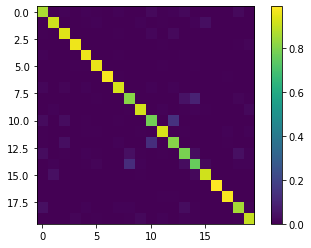

In [ ]:
from sklearn.metrics import confusion_matrix
# Plot confusion matrix
C = confusion_matrix(yts,predictions)

# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[:, None]

# Print the confusion matrix
# print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

In [ ]:
import pickle
# save the model
with open( "best_xgboost.sav", "wb" ) as fp:
    pickle.dump( model, fp )